In [1]:
import numpy as np
from urllib.request import urlopen
import scipy.optimize
import random
from math import exp
from math import log

In [2]:
def parseData(fname):
  for l in urlopen(fname):
    yield eval(l)



In [3]:
print("Reading data...")
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))
print("done")

Reading data...
done


In [4]:
def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

In [5]:
X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]

In [6]:
def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

 


### Logistic regression by gradient ascent  


#### NEGATIVE Log-likelihood

In [7]:
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)): 
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood 

#### NEGATIVE Derivative of log-likelihood

In [8]:
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return np.array([-x for x in dl])

In [9]:
rand_data = random.sample(data, int(len(data)))

In [10]:
X = [feature(d) for d in rand_data]
y = [d['beer/ABV'] >= 6.5 for d in rand_data]

In [11]:
n_train = int(len(rand_data) * (1/3))

X_train = X[:n_train]
y_train = y[:n_train]



In [12]:
n_test = int((len(rand_data) - n_train) * (1/2))

X_test = X[n_train:(n_train+n_test)]
y_test = y[n_train:(n_train+n_test)]


In [13]:
X_val = X[n_train+n_test:]
y_val = y[n_train+n_test:]


#### Train

In [14]:
def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta


#### Predict 

In [15]:
def performance(theta, X, y):
    scores = [inner(theta,x) for x in X]
    predictions = [s > 0 for s in scores]
    correct = [(a==b) for (a,b) in zip(predictions,y)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc


#### Validation pipeline 

In [16]:
lam = 1.0

theta = train(lam)


In [17]:
val_acc = performance(theta, X_val, y_val)
test_acc = performance(theta, X_test, y_test)

In [18]:
print("lambda = " + str(lam) + ":\tvalidation accuracy = " + str(val_acc))
print("lambda = " + str(lam) + ":\ttest accuracy = " + str(test_acc))

lambda = 1.0:	validation accuracy = 0.7169856602867942
lambda = 1.0:	test accuracy = 0.7217255654886903


### Q2

In [19]:
def performance(theta, X, y):
    scores = [inner(theta,x) for x in X]
    predictions = [s > 0 for s in scores]
    
    true_pos = [(1 if(a==b and a==1) else 0) for (a,b) in zip(predictions, y)]
    true_pos = sum(true_pos)
    
    true_neg = [(1 if(a==b and a==0) else 0) for (a,b) in zip(predictions, y)]
    true_neg = sum(true_neg)
    
    false_pos = [(1 if(a!=b and a==1) else 0) for (a,b) in zip(predictions, y)]
    false_pos = sum(false_pos)
    
    false_neg = [(1 if(a!=b and a==0) else 0) for (a,b) in zip(predictions, y)]
    false_neg = sum(false_neg)
    
    true_pos_rate = float(true_pos)/float((true_pos+false_neg))
    true_neg_rate = float(true_neg)/float((true_neg+false_pos))
    BER = 1 - 0.5*(true_pos_rate + true_neg_rate)
    
    return true_pos, true_neg, false_pos, false_neg, BER

In [20]:
true_pos, true_neg, false_pos, false_neg, BER = performance(theta, X_test, y_test)
print("lambda = " + str(lam) + ":\t# of true postives = " + str(true_pos))
print("lambda = " + str(lam) + ":\t# of true negative = " + str(true_neg))
print("lambda = " + str(lam) + ":\t# of false postives = " + str(false_pos))
print("lambda = " + str(lam) + ":\t# of false negatives = " + str(false_neg))
print("lambda = " + str(lam) + ":\tBalanced Error Rate = " + str(BER))

lambda = 1.0:	# of true postives = 9113
lambda = 1.0:	# of true negative = 2916
lambda = 1.0:	# of false postives = 3319
lambda = 1.0:	# of false negatives = 1319
lambda = 1.0:	Balanced Error Rate = 0.32937772279237043


#### Q3 

Assigning more importance to FP means that the predictor will predict FP at higher accuracy therefore reduce the number of FP than before.
To achieve this, I need to lower the possibility of predicting positive.

In [21]:
def sigmoid1(x):
  return 1.0 / (1 + exp(-x))

In [27]:
def f1(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime1(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid1(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return np.array([-x for x in dl])

In [28]:
def train1(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f1, [0]*len(X[0]), fprime1, pgtol = 10, args = (X_train, y_train, lam))
  return theta
lam = 1
theta = train1(lam)

In [29]:
true_pos, true_neg, false_pos, false_neg, BER = performance(theta, X_test, y_test)
false_pos

3319

### Q4

In [25]:
ber = {}
for lam in [0, 0.01, 0.1, 1, 100]:
    theta = train(lam)
    val_ber = performance(theta, X_val, y_val)[4]
    ber[val_ber] = lam
    print("lambda = " + str(lam) + ":\tvalidation balanced error rate = " + str(val_ber))

best_ber = min(ber.keys())
best_lam = ber[best_ber]
theta = train(best_lam)
train_ber = performance(theta, X_train, y_train)[4]
val_ber = performance(theta, X_val, y_val)[4]
test_ber = performance(theta, X_test, y_test)[4]
print()
print("best value of lambda = " + str(lam) + ":\ttrain balanced error rate = " + str(train_ber))
print("best value of lambda = " + str(lam) + ":\tvalidation balanced error rate = " + str(val_ber))
print("best value of lambda = " + str(lam) + ":\ttest balanced error rate = " + str(test_ber))

lambda = 0:	validation balanced error rate = 0.3321638727733528
lambda = 0.01:	validation balanced error rate = 0.33202129345905806
lambda = 0.1:	validation balanced error rate = 0.3320564381370883
lambda = 1:	validation balanced error rate = 0.3325546340691665
lambda = 100:	validation balanced error rate = 0.4209951010541717

best value of lambda = 100:	train balanced error rate = 0.32989111313036745
best value of lambda = 100:	validation balanced error rate = 0.33202129345905806
best value of lambda = 100:	test balanced error rate = 0.3292136172827055


### Q5

In [26]:
import sys
!{sys.executable} -m pip install networkx

  Using cached https://files.pythonhosted.org/packages/bc/bb/a24838832ba35baf52f32ab1a49b906b5f82fb7c76b2f6a7e35e140bac30/decorator-4.3.0-py2.py3-none-any.whl


In [430]:
import networkx as nx
import matplotlib.pyplot as plt

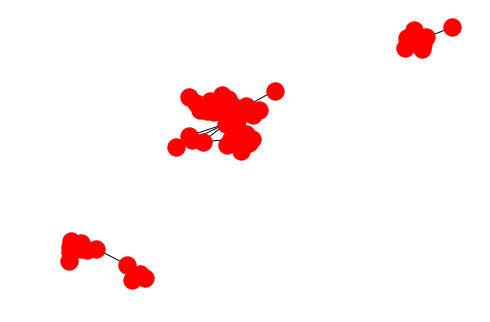

<Figure size 432x288 with 0 Axes>

In [431]:
edges = set()
nodes = set()
for edge in urllib.request.urlopen("http://jmcauley.ucsd.edu/cse258/data/facebook/egonet.txt"):
  x,y = edge.split()
  x,y = int(x),int(y)
  edges.add((x,y))
  edges.add((y,x))
  nodes.add(x)
  nodes.add(y)
    
G = nx.Graph()
for e in edges:
  G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()

In [432]:
component = len(list(nx.connected_component_subgraphs(G)))
print(str(component) + " connected components are in the graph.")

3 connected components are in the graph.


In [433]:
largest = max(nx.connected_component_subgraphs(G), key=len)
type(largest)
print(largest.nodes())

[774, 708, 729, 863, 819, 753, 856, 869, 713, 828, 719, 697, 823, 810, 889, 880, 769, 890, 800, 747, 745, 805, 886, 840, 878, 876, 830, 703, 882, 861, 811, 864, 804, 772, 888, 825, 803, 893, 884, 798]


In [434]:
print(str(nx.number_of_nodes(largest)) + " nodes are in the largest component.")

40 nodes are in the largest component.


### Q6

In [435]:
highest = sorted(largest.nodes())[21:]

In [436]:
lowest = sorted(largest.nodes())[:21]

In [437]:
def nedges(graph, cluster1, cluster2):
    boundary_edge_iter = nx.edge_boundary(graph,cluster1,cluster2)
    boundary_edges = sum(1 for _ in boundary_edge_iter)
    return boundary_edges

In [438]:
high = sum([largest.degree[v] for v in highest])
low = sum([largest.degree[w] for w in lowest])
total_edges = nedges(largest, highest, lowest)
Cost = (total_edges/high + total_edges/low) / 2
print("The normalized-cut cost of the 50/50 split is "+str(Cost))

The normalized-cut cost of the 50/50 split is 0.3948717948717949


### Q7

In [439]:
def Tdegree(g, c):
    degree = sum([g.degree[v] for v in c])
    return degree


In [440]:
def cut_cost(g, c1, c2):
    N = nedges(g, c1, c2)
    sum1 = Tdegree(g, c1)
    sum2 = Tdegree(g, c2)
    return (N/sum1 + N/sum2) / 2

In [441]:
# for each node in high, calculate normalized cut cost after moving to low
# for each node in low, calculate normalized cut cost after moving to high
# choose node move resulting in lowest normalized cut cost.
# Repeat

In [442]:
def lowest_cost_node(g, c1, c2):

    min_cost = float('inf')

    for n in c1:
        trial_set1 = c1.copy()
        trial_set2 = c2.copy()
        trial_set1.remove(n)
        trial_set2.append(n)

        c = cut_cost(g,trial_set1,trial_set2)
        if c < min_cost:
            min_cost = c
            min_node = n
        elif c == min_cost:
            if n < min_node:
                min_node = n

        #N = nedges(largest, trial_set1, trial_set2)
        #sum1 = Tdegree(largest, trial_set1)
        #sum2 = Tdegree(largest, trial_set2)
        #print("N: " + str(N) + " sum1: " + str(sum1) + " sum2: " + str(sum2) + "cut cost:" + str(c))

    print( "min node: " + str(min_node) + " min cost: " + str(min_cost)  )
    return min_node,min_cost

In [443]:
while True:
    # FIRST calculate current cut cost
    cur_cost = cut_cost(largest, highest, lowest)
    print("cur_cost: " + str(cur_cost))
    # find smallest cost move from high to low
    h2l_node,h2l_cost = lowest_cost_node(largest, highest, lowest)
    # find smallest cost move from low to high
    l2h_node,l2h_cost = lowest_cost_node(largest, lowest, highest)
    # if one of those moves is less than current cut, then move node and repeat
    if h2l_cost < l2h_cost and h2l_cost < cur_cost:
        #move node from highest to lowest
        highest.remove(h2l_node)
        lowest.append(h2l_node)
        print("moving node: " + str(h2l_node))
    elif l2h_cost < h2l_cost and l2h_cost < cur_cost:
        # move node from lowest to highest
        lowest.remove(l2h_node)
        highest.append(l2h_node)
        print("moving node: " + str(l2h_node))
    elif l2h_cost == h2l_cost:
        # move node with lower index
        if l2h_node < h2l_node:
            lowest.remove(l2h_node)
            highest.append(l2h_node)
            print("moving node: " + str(l2h_node))
        else:
            highest.remove(h2l_node)
            lowest.append(h2l_node)
            print("moving node: " + str(h2l_node))
    else:
        # done
        break
        
print("The first cluster is: " + str(highest))
print("The second cluster is: " + str(lowest))
print("The minimum normalized cut cost is: " + str(cut_cost(largest, highest, lowest)))


cur_cost: 0.3948717948717949
min node: 828 min cost: 0.3575324472940181
min node: 729 min cost: 0.3561891545238546
moving node: 729
cur_cost: 0.3561891545238546
min node: 828 min cost: 0.314994793474488
min node: 804 min cost: 0.31117397454031115
moving node: 804
cur_cost: 0.31117397454031115
min node: 828 min cost: 0.26663264655227403
min node: 803 min cost: 0.3059678256357032
moving node: 828
cur_cost: 0.26663264655227403
min node: 830 min cost: 0.2257691215965414
min node: 803 min cost: 0.2607738548810431
moving node: 830
cur_cost: 0.2257691215965414
min node: 840 min cost: 0.17876489707475623
min node: 803 min cost: 0.21954182575494618
moving node: 840
cur_cost: 0.17876489707475623
min node: 880 min cost: 0.14714361493576883
min node: 753 min cost: 0.17854401087934021
moving node: 880
cur_cost: 0.14714361493576883
min node: 890 min cost: 0.1295001295001295
min node: 753 min cost: 0.14732142857142858
moving node: 890
cur_cost: 0.1295001295001295
min node: 869 min cost: 0.11129580111

#### Q8

In [444]:
def best_community_node(g, c1, c2):

    max_community = -float('inf')

    for n in c1:
        trial_set1 = c1.copy()
        trial_set2 = c2.copy()
        trial_set1.remove(n)
        trial_set2.append(n)

        c = community(g,trial_set1,trial_set2)
        if c > max_community:
            max_community = c
            max_node = n
        elif c == max_community:
            if n < max_node:
                max_node = n


    print( "max node: " + str(max_node) + " mac community: " + str(max_community)  )
    return max_node,max_community

In [445]:
def community(g, c1, c2):

    total_edges = 0
    for e in g.edges():
        total_edges += 1

    total_endpoints = total_edges * 2

    s1 = g.subgraph(c1)
    e1 = Tdegree(s1, c1) / total_endpoints
    a1 = Tdegree(g, c1) / total_endpoints
    
    C1 = e1 - (a1 ** 2)
    
    s2 = g.subgraph(c2)
    e2 = Tdegree(s2, c2) / total_endpoints
    a2 = Tdegree(g, c2) / total_endpoints
    
    C2 = e2 - (a2 ** 2)

    return (C1 + C2)

In [446]:
highest = sorted(largest.nodes())[21:]


lowest = sorted(largest.nodes())[:21]


In [447]:

while True:
    # FIRST calculate current community
    cur_comm = community(largest, highest, lowest)
    print("cur_comm: " + str(cur_comm))
    # find smallest cost move from high to low
    h2l_node,h2l_cost = best_community_node(largest, highest, lowest)
    # find smallest cost move from low to high
    l2h_node,l2h_cost = best_community_node(largest, lowest, highest)
    # if one of those moves is less than current cut, then move node and repeat
    if h2l_cost > l2h_cost and h2l_cost > cur_comm:
        #move node from highest to lowest
        highest.remove(h2l_node)
        lowest.append(h2l_node)
        print("moving node: " + str(h2l_node))
    elif l2h_cost > h2l_cost and l2h_cost > cur_comm:
        # move node from lowest to highest
        lowest.remove(l2h_node)
        highest.append(l2h_node)
        print("moving node: " + str(l2h_node))
    elif l2h_cost == h2l_cost:
        # move node with lower index
        if l2h_node < h2l_node:
            lowest.remove(l2h_node)
            highest.append(l2h_node)
            print("moving node: " + str(l2h_node))
        else:
            highest.remove(h2l_node)
            lowest.append(h2l_node)
            print("moving node: " + str(h2l_node))
    else:
        # done
        break
        
print("Cluster one: " + str(highest))
print("Cluster two: " + str(lowest))
print("Max modularity values for the 50/50 spl is: " + str(community(largest, highest, lowest)))

cur_comm: 0.1016528925619834
max node: 828 mac community: 0.13222107438016542
max node: 729 mac community: 0.1413119834710744
moving node: 729
cur_comm: 0.1413119834710744
max node: 828 mac community: 0.17619834710743798
max node: 804 mac community: 0.18756198347107442
moving node: 804
cur_comm: 0.18756198347107442
max node: 828 mac community: 0.22676652892561983
max node: 803 mac community: 0.1931301652892563
moving node: 828
cur_comm: 0.22676652892561983
max node: 830 mac community: 0.2594938016528925
max node: 803 mac community: 0.2335123966942149
moving node: 830
cur_comm: 0.2594938016528925
max node: 840 mac community: 0.2940495867768594
max node: 803 mac community: 0.26710743801652886
moving node: 840
cur_comm: 0.2940495867768594
max node: 880 mac community: 0.31610537190082644
max node: 753 mac community: 0.30279958677685953
moving node: 880
cur_comm: 0.31610537190082644
max node: 890 mac community: 0.32511363636363627
max node: 753 mac community: 0.3264462809917356
moving node: